# Libraries <a class="anchor" id="section1"></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt

# Data <a class="anchor" id="section1"></a>

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data

,Unnamed: 0,area_type,availability,bedrooms,total_sqft,bath,balcony,ranked,price in rupees
0,0,B,1,3.0,1655.0,3.0,1.0,134,10800000.0
1,1,B,1,2.0,1102.0,2.0,1.0,134,4800000.0
2,2,B,0,2.0,1112.0,2.0,1.0,242,8800000.0
3,3,B,1,3.0,1450.0,3.0,3.0,335,5100000.0
4,4,B,1,2.0,1010.0,2.0,1.0,261,4100000.0
...,...,...,...,...,...,...,...,...,...
12558,12558,B,1,3.0,1720.0,3.0,3.0,134,9897000.0
12559,12559,B,0,3.0,1275.0,3.0,2.0,276,4400000.0
12560,12560,P,1,2.0,1550.0,2.0,1.0,252,7100000.0
12561,12561,B,1,3.0,1535.0,3.0,1.0,307,7200000.0


In [4]:
# delete uneeded columns
del data['Unnamed: 0']

# Data Structure For Implementing The Algorithms <a class="anchor" id="section1"></a>

In [5]:
class Node(object):
    def __init__(self, classASize, classBSize, pathValue1, pathValue2, score, df, feature):
        self.classASize = classASize
        self.classBSize = classBSize
        self.pathValue1 = pathValue1
        self.pathValue2 = pathValue2
        self.score = score
        self.df = df
        self.feature = feature
        self.left = None
        self.right = None

class BinaryTree(object):
    def __init__(self, classASize, classBSize, pathValue1, pathValue2, score, df, feature):
        self.root = Node(classASize, classBSize, pathValue1, pathValue2, score, df, feature)         

# Classification: Decision Tree & AdaBoost <a class="anchor" id="section1"></a>

### Gini Functions

In [6]:
# calculate weighted gini score for nodes with left and right nodes
def calcGiniCategorical(leftNode, rightNode):   
    leftNode_total = leftNode.classASize + leftNode.classBSize
    rightNode_total = rightNode.classASize + rightNode.classBSize
    
    #avoiding division by 0
    if leftNode_total == 0 or rightNode_total == 0:
        return -1
    
    gini_left = 1 - pow(leftNode.classASize / leftNode_total, 2) - pow(leftNode.classBSize / leftNode_total, 2)
    gini_right = 1 - pow(rightNode.classASize / rightNode_total, 2) - pow(rightNode.classBSize / rightNode_total, 2)
    
    total = leftNode_total + rightNode_total
    
    weighted_gini = (leftNode_total / total) * gini_left + (rightNode_total / total) * gini_right
        
    return weighted_gini

In [7]:
# calculate gini score for internal nodes, NOTE: this is not the weighted average 
def calcGiniOneNodeCategorical(node):   
    node_size = node.classASize + node.classBSize
    
    #avoiding division by 0
    if node_size == 0:
        return -1
    else:
        gini_score = 1 - pow(node.classASize / node_size, 2) - pow(node.classBSize / node_size, 2)
            
    return gini_score

### Performance Say Function For AdaBoost

In [8]:
# this function calculates the performance say for each given stump
def calcPerformanceSay(node):
    left_A_Size = node.left.classASize
    left_B_Size = node.left.classBSize
    
    right_A_Size = node.right.classASize
    right_B_Size = node.right.classBSize
    
    overall_size = left_A_Size + left_B_Size + right_A_Size + right_B_Size
    
    total_error = 0
    
    if left_A_Size < left_B_Size:
        total_error = total_error + (left_A_Size / overall_size)
    else:
        total_error = total_error + (left_B_Size / overall_size)
        
    if right_A_Size < right_B_Size:
        total_error = total_error + (right_A_Size / overall_size)
    else:
        total_error = total_error + (right_B_Size / overall_size)
        
    perf_say = 0.5 * np.log((1 - total_error) / total_error)
    
    return perf_say

### Consecutive Averages Function 

In [9]:
def consecutive_avgs(data):
    # Python code to find average of each consecutive segment
  
    # Defining Splits
    splits = 2
  
    # Finding average of each consecutive segment
    Output = [sum(data[i:i + splits])/splits
              for i in range(len(data) - splits + 1)]
  
    return Output

### Classification Tree & AdaBoost Models

In [10]:
class classification_Tree(object):  
    def __init__(self, max_depth = None, min_samples_split = 2, target_feature = None, features = None):
        self.max_depth = 6 if max_depth is None else max_depth
        self.min_samples_split = 2 if min_samples_split is None else min_samples_split
        self.target_feature = None if target_feature is None else target_feature
        self.features = features
 
    # replace None values with 0, else return the value
    def checkNone(self, values_list, val):
        if val not in values_list.index.values:
            return 0
        return values_list[val]
    
    # split the data for each feature and return the best split with lowest Gini value
    def best_split(self, df):  
        # main stump that will contain the best split
        main_tree = BinaryTree(None, None, None, None, None, None, None)

        # this list stores all features with thier lowest gini value
        gini_list = {}
        
        target_feat_vals = data[self.target_feature].unique()
        target_feat_vals.sort()
        
        # iterate through the features to calculate gini value
        for feature in list(self.features.keys()):
            tree = BinaryTree(None,None, None, None, None, None, feature)
            mini_df = df.loc[:, [self.target_feature, feature]]
            if df[feature] is None:
                continue
            if self.features[feature]: 
                feat_vals = data[feature].unique()
                feat_vals.sort()
                if (mini_df[(mini_df[feature] == feat_vals[0])]).empty or (mini_df[(mini_df[feature] == feat_vals[1])]).empty:
                    continue
                
                df_filtered_classA = mini_df[(mini_df[feature] == feat_vals[0])]
                df_filtered_classB = mini_df[(mini_df[feature] == feat_vals[1])] 
                
                filtered_classA_byTarget = df_filtered_classA[self.target_feature].value_counts()
                filtered_classB_byTarget = df_filtered_classB[self.target_feature].value_counts()
                
                tree.root.left = Node(self.checkNone(filtered_classA_byTarget, target_feat_vals[0]), self.checkNone(filtered_classA_byTarget, target_feat_vals[1]), None, None, None, df_filtered_classA, feature)
                tree.root.right = Node(self.checkNone(filtered_classB_byTarget, target_feat_vals[0]), self.checkNone(filtered_classB_byTarget, target_feat_vals[1]), None, None, None, df_filtered_classB, feature)
   
                tree.root.left.gini_score = calcGiniOneNodeCategorical(tree.root.left)
                tree.root.right.gini_score = calcGiniOneNodeCategorical(tree.root.right)
            
                if feature not in gini_list:
                    gini_list[feature] = list()
                    gini_list[feature].extend([calcGiniCategorical(tree.root.left, tree.root.right)])

            else:
                selected_col = df.loc[:, feature]
                unique_vals = selected_col.unique()
                sorted_vals = np.sort(unique_vals)
                avg_list = consecutive_avgs(sorted_vals)
                continuous_gini_list = {}
                 
                if len(avg_list) > 0:     
                    for i in avg_list:   
                        if (mini_df[(mini_df[feature] < i)]).empty or (mini_df[(mini_df[feature] > i)]).empty:
                            continue
                
                        df_filtered_classA = mini_df[(mini_df[feature] < i)]
                        df_filtered_classB = mini_df[(mini_df[feature] > i)]
       
                        filtered_classA_byTarget = df_filtered_classA[self.target_feature].value_counts()
                        filtered_classB_byTarget = df_filtered_classB[self.target_feature].value_counts()
            
                        tree.root.left = Node(self.checkNone(filtered_classA_byTarget, target_feat_vals[0]), self.checkNone(filtered_classA_byTarget, target_feat_vals[1]), None, None, None, df_filtered_classA, feature)
                        tree.root.right = Node(self.checkNone(filtered_classB_byTarget, target_feat_vals[0]), self.checkNone(filtered_classB_byTarget, target_feat_vals[1]), None, None, None, df_filtered_classB, feature)
   
                        continuous_gini_list[i] = calcGiniCategorical(tree.root.left, tree.root.right)
        
                    min_gini_index = min(continuous_gini_list, key=continuous_gini_list.get)

                    if feature not in gini_list:
                        gini_list[feature] = list()
                        gini_list[feature].extend([min_gini_index, continuous_gini_list[min_gini_index]])
                
        min_gini = 999
        min_gini_feature = None
        
        # find the lowest gini value and its feature
        for k, v in gini_list.items():
            if not self.features[k]:
                if v[1] != -1:
                    if v[1] < min_gini:
                        min_gini = v[1]
                        min_gini_feature = k
            else:
                if v[0] != -1:
                    if v[0] < min_gini:
                        min_gini = v[0]
                        min_gini_feature = k
        

        # make sure gini values are between 0 and 1
        if (min_gini < 0) or (min_gini > 1):
            return None
        
        # create the tree with 2 nodes(stump) base on the feature with lowest gini value
        if self.features[min_gini_feature]:
            feat_vals = data[min_gini_feature].unique()
            feat_vals.sort()
            filtered_class_byTarget = df[self.target_feature].value_counts()
            
            main_tree.root = Node(self.checkNone(filtered_class_byTarget, target_feat_vals[0]), self.checkNone(filtered_class_byTarget, target_feat_vals[1]), feat_vals[0], feat_vals[1], gini_list[min_gini_feature][0], df, min_gini_feature)
           
            father_df = main_tree.root.df
            if (father_df[father_df[main_tree.root.feature] == main_tree.root.pathValue1]).empty or (father_df[father_df[main_tree.root.feature] == main_tree.root.pathValue2]).empty:
                return None
            
            leftNode_df = father_df[father_df[main_tree.root.feature] == main_tree.root.pathValue1]
            rightNode_df = father_df[father_df[main_tree.root.feature] == main_tree.root.pathValue2]

            main_tree.root.left = Node(self.checkNone(leftNode_df[self.target_feature].value_counts(), target_feat_vals[0]), self.checkNone(leftNode_df[self.target_feature].value_counts(), target_feat_vals[1]), None, None, None, leftNode_df, None)
            main_tree.root.right = Node(self.checkNone(rightNode_df[self.target_feature].value_counts(), target_feat_vals[0]), self.checkNone(rightNode_df[self.target_feature].value_counts(), target_feat_vals[1]), None, None, None, rightNode_df, None)
        else:  
            filtered_class_byTarget = df[self.target_feature].value_counts()
            
            main_tree.root = Node(self.checkNone(filtered_class_byTarget, target_feat_vals[0]), self.checkNone(filtered_class_byTarget, target_feat_vals[1]), (-1 * gini_list[min_gini_feature][0]), gini_list[min_gini_feature][0], gini_list[min_gini_feature][1], df, min_gini_feature)
           
            father_df = main_tree.root.df
            if (father_df[father_df[main_tree.root.feature] < abs(main_tree.root.pathValue1)]).empty or (father_df[father_df[main_tree.root.feature] > main_tree.root.pathValue2]).empty:
                return None
            
            leftNode_df = father_df[father_df[main_tree.root.feature] < abs(main_tree.root.pathValue1)]
            rightNode_df = father_df[father_df[main_tree.root.feature] > main_tree.root.pathValue2]

            main_tree.root.left = Node(self.checkNone(leftNode_df[self.target_feature].value_counts(), target_feat_vals[0]), self.checkNone(leftNode_df[self.target_feature].value_counts(), target_feat_vals[1]), None, None, None, leftNode_df, None)
            main_tree.root.right = Node(self.checkNone(rightNode_df[self.target_feature].value_counts(), target_feat_vals[0]), self.checkNone(rightNode_df[self.target_feature].value_counts(), target_feat_vals[1]), None, None, None, rightNode_df, None)
   
        # if the weighted gini value is bigger than the normal gini value then return None
        if main_tree.root.score > calcGiniOneNodeCategorical(main_tree.root):
            return None
        return main_tree.root
            

    # recursive function to build the tree with each best split
    def add_node(self, root, depth):
        if (root is None) or (root.left is None) or (root.right is None):
            return
        if root.classASize == 0:
            return
        if root.classBSize == 0:
            return
        if (root.classASize + root.classBSize) < self.min_samples_split:
            return
        if root.score == -1:
            return
        
        if depth > self.max_depth:
            return;
        
        root.left = self.add_node(self.best_split(root.left.df), depth + 1)
        root.right = self.add_node(self.best_split(root.right.df), depth + 1)
        return root;
    
    # train adaboost model
    def train_adaboost(self, train_adaboost_data, k_stumps):        
        target_feat_vals = train_adaboost_data[self.target_feature].unique()
        target_feat_vals.sort()
        
        filtered_class_byTarget = train_adaboost_data[self.target_feature].value_counts()
        stump = BinaryTree(filtered_class_byTarget[target_feat_vals[0]],filtered_class_byTarget[target_feat_vals[1]], None, None, None, train_adaboost_data, None)
        stump.root = self.best_split(stump.root.df)

        # store all stumps with their amount of say
        stumps_amount_of_say = {}

        #create k stumps
        for k in range(0, k_stumps):
            tmp_df = stump.root.df.copy()
            #inital weight
            tmp_df["SampleWeight"] = 1 / len(tmp_df.index)
        
            #performance say
            perf_say = calcPerformanceSay(stump.root)
            
            # calculate the new sample weights for each stump
            for i in range(train_adaboost_data.index[0], train_adaboost_data.index[-1]):
                dff = tmp_df.loc[i:i, :]
                output = self.test_tree(stump.root, dff)
                if output == dff.iloc[0][self.target_feature]:
                    prev_weight = tmp_df.at[i,'SampleWeight']
                    tmp_df.at[i,'SampleWeight'] = prev_weight * pow(np.exp(1), -1 * perf_say)
                else:
                    prev_weight = tmp_df.at[i,'SampleWeight']
                    tmp_df.at[i,'SampleWeight'] = prev_weight * pow(np.exp(1), perf_say)
        
            # normalize Sample Weight column
            tmp_df["SampleWeight"] = tmp_df["SampleWeight"] / sum(tmp_df["SampleWeight"])
            new_df = tmp_df.copy()
            
            sel_col = new_df[["SampleWeight"]]
            res = sel_col.cumsum(axis = 0)
            
            # fill the new dataframe with new data from the old dataframe
            for i in range(train_adaboost_data.index[0], train_adaboost_data.index[-1]):
                rand = random.uniform(0, 1)
                #cur_sum = 0
                row_index = res[res['SampleWeight'].gt(rand)].index[0]
                new_df.loc[i] = tmp_df.loc[row_index]

                    
            del new_df['SampleWeight']

            stumps_amount_of_say[stump.root] = perf_say
                
            filtered_class_byTarget = new_df[self.target_feature].value_counts()
            stump.root.df = new_df
            stump.classASize = filtered_class_byTarget[target_feat_vals[0]]
            stump.classBSize = filtered_class_byTarget[target_feat_vals[1]]
            stump.root = self.best_split(stump.root.df)
            
        return stumps_amount_of_say
  

    # test AdaBoost Model
    def test_adaboost(self, stumps_amounts_ofSay, test_data):
        counter_true = 0
        counter_false = 0
        
        target_feat_vals = data[self.target_feature].unique()
        target_feat_vals.sort()
        
        tp = 0
        fn = 0
        fp = 0
        tn = 0
            
        for i in range(test_data.index[0], test_data.index[-1]):
            sum_say_true = 0
            sum_say_false = 0
            result = None
            #calculate sum of true and false amount of say for each row
            for k,v in stumps_amounts_ofSay.items():
                dff = test_data.loc[i:i, :]
                output = self.test_tree(k, dff)
                if output == target_feat_vals[0]:
                    sum_say_true = sum_say_true + v
                else:
                    sum_say_false = sum_say_false + v
     
            # decide to which class the row is classified
            if sum_say_true > sum_say_false:
                result = target_feat_vals[0]
            else:
                result = target_feat_vals[1]
    
            dff2 = test_data.loc[i:i, :]

            # check the actual class of the current row
            if result == dff2.iloc[0][self.target_feature]:
                counter_true = counter_true + 1
            else:
                counter_false = counter_false + 1
            
            # Sensitivity & Specificity
            if result == target_feat_vals[0]:
                if result == dff.iloc[0][self.target_feature]:
                    tp = tp + 1
                else:
                    fp = fp + 1
            else:
                if result == dff.iloc[0][self.target_feature]:
                    tn = tn + 1
                else:
                    fn = fn + 1

        
        print("tp: " + str(tp))
        print("fn: " + str(fn))
        print("fp: " + str(fp))
        print("tn: " + str(tn))

        print("Sensitivity: " + str(tp / (tp + fn)))
        print("Specificity: " + str(tn / (tn + fp)))
        print("Accuracy: " + str((tp + tn) / (tp + tn + fp + fn)))

 
        return counter_true / (counter_true + counter_false)
    
    def validate_adaboost(self, parms_list, val_data):
        iterations_num = []
        iterations_acc = []
        acc = 0
        best_k = 0
        for k in range(parms_list["k_stumps"][0], parms_list["k_stumps"][1] + 10, 10):
            iterations_num.append(k)
            print("k: " + str(k))
            stumps_amount_ofSay = self.train_adaboost(val_data, k)
            cur_acc = self.test_adaboost(stumps_amount_ofSay, val_data)
            iterations_acc.append(cur_acc)
            if acc < cur_acc:
                acc = cur_acc
                best_k = k
        
        plt.plot(iterations_num, iterations_acc, color='red', marker='o')
        plt.title('Accuracy Vs Number Of Stumps')
        plt.xlabel('Stumps Number')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.show()
        
        return best_k
        
        
    # train and test the Classification Tree Model
    def train_test_model(self, df, train_data, test_data):
        #train_data = df.loc[:8040, :]
        
        filtered_class_byTarget = train_data[self.target_feature].value_counts()
        
        # get categorical values of target feature
        target_feat_vals = data[self.target_feature].unique()
        target_feat_vals.sort()
        
        #initalize tree parameters with the original training data
        tree = BinaryTree(filtered_class_byTarget[target_feat_vals[0]],filtered_class_byTarget[target_feat_vals[1]], None, None, None, train_data, None)
   
        #Inital tree to start with
        tree.root = self.best_split(tree.root.df)
        
        #call the best_split function to create the whole tree and return the root of that tree
        class_tree = self.add_node(tree.root, 0)
        
        tp = 0
        fn = 0
        fp = 0
        tn = 0
        # Sensitivity & Specificity
        for i in range(test_data.index[0], test_data.index[-1]):
            dff = data.loc[i:i, :]
            output = self.test_tree(class_tree, dff)
            if output == target_feat_vals[0]:
                if output == dff.iloc[0][self.target_feature]:
                    tp = tp + 1
                else:
                    fp = fp + 1
            else:
                if output == dff.iloc[0][self.target_feature]:
                    tn = tn + 1
                else:
                    fn = fn + 1

        
        print("tp: " + str(tp))
        print("fn: " + str(fn))
        print("fp: " + str(fp))
        print("tn: " + str(tn))

        print("Sensitivity: " + str(tp / (tp + fn)))
        print("Specificity: " + str(tn / (tn + fp)))
        print("Accuracy: " + str((tp + tn) / (tp + tn + fp + fn)))

        return (tp + tn) / (tp + tn + fp + fn)
        
    # this function validates the model with given hyper-parameters
    def validate_model(self, df, parms_list, validation_data):
        #validation_data = df.loc[8041:10050, :]
        max_depth = 0
        best_acc = 0
        depths = []
        depth_acc = []
        for i in range(parms_list["max_depth"][0], parms_list["max_depth"][1] + 1):
            depths.append(i)
            self.max_depth = i
        
            filtered_class_byTarget = validation_data[self.target_feature].value_counts()
        
            # get categorical values of target feature
            target_feat_vals = data[self.target_feature].unique()
            target_feat_vals.sort()
            
            tree = BinaryTree(filtered_class_byTarget[target_feat_vals[0]],filtered_class_byTarget[target_feat_vals[1]], None, None, None, df, None)
        
            tree.root = self.best_split(tree.root.df)
        
            test = self.add_node(tree.root, 0)
        
            counter_true = 0
            counter_false = 0
        
            for j in range(validation_data.index[0], validation_data.index[-1]):
                dff = data.loc[j:j, :]
                output = self.test_tree(test, dff)
                if output == dff.iloc[0][self.target_feature]:
                    counter_true = counter_true + 1
                else:
                    counter_false = counter_false + 1
        
            cur_acc = counter_true / (counter_true + counter_false)
            if cur_acc > best_acc:
                best_acc = cur_acc
                max_depth = i
                
            depth_acc.append(cur_acc)
        
        plt.plot(depths, depth_acc, color='red', marker='o')
        plt.title('Accuracy Vs Tree Depth')
        plt.xlabel('Depth')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.show()
        return max_depth
    
    # this function returns the output for each given row
    def test_tree(self, root, row):
        while(root.left is not None and root.right is not None):
            tmp = row[root.feature].tolist()
            tmp.sort()
            if self.features[root.feature]:
                if tmp[0] == root.left.pathValue1:
                    root = root.left
                else:
                    root = root.right
            else:   
                if tmp[0] < root.pathValue2:
                    root = root.left
                else:
                    root = root.right

        
        target_feat_vals = data[self.target_feature].unique()
        target_feat_vals.sort()
        if root.classASize > root.classBSize:
            return target_feat_vals[0]
        else:
            return target_feat_vals[1]
                

### Classification Data

In [11]:
# True = Categorical, False = Continuous
target_feat = "area_type"
features_list = {"bedrooms":False, "price in rupees":False, "ranked":False, "total_sqft":False, "balcony":False, "bath":False, "availability":True}

In [12]:
X_cls_train = data.loc[:8040, :]
X_cls_validate = data.loc[8041:10050, :]
X_cls_test = data.loc[10051:12563, :]

### Define The Decision Tree Model


In [13]:
class_model = classification_Tree(6, 2, target_feat, features_list)

### Fit The Decsion Tree Model
### Note: Only Max Depth Can Be Tuned


In [14]:
# define parameter grid
parameters_grid = {
    'max_depth': [2, 10],
}

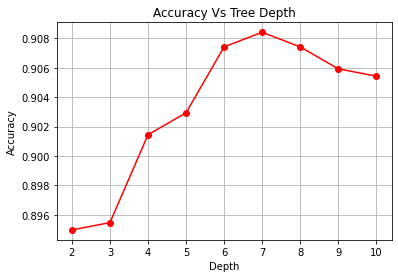

In [15]:
class_best_depth = class_model.validate_model(X_cls_train, parameters_grid, X_cls_validate)

In [16]:
class_best_depth

7

In [17]:
class_model.max_depth = class_best_depth

### Predict And Evaluate The Decision Tree Model

In [18]:
# check the bias of the model
class_model.train_test_model(data, X_cls_train, X_cls_train)

tp: 6706
fn: 150
fp: 437
tn: 747
Sensitivity: 0.9781213535589265
Specificity: 0.6309121621621622
Accuracy: 0.9269900497512438


0.9269900497512438

In [19]:
# check the actual accuracy of the model using new test data
dt_accuracy = class_model.train_test_model(data, X_cls_train, X_cls_test)

tp: 2068
fn: 93
fp: 145
tn: 205
Sensitivity: 0.956964368347987
Specificity: 0.5857142857142857
Accuracy: 0.9052170450019913


### Section D Answer: We can see that we got a pretty high score for Sensitivity compared to Specificity which has a low score,  "A highly sensitive test means that there are few false negative results, and thus fewer cases of the predicted feature are missed", meanwhile "A test with low specificity can be thought of as being too eager to find a positive result, even when it is not present, and may give a high number of false positives."
### So long story short we need to lower the number of fp cases in our model, but how do we do that? Since our categorical features do not have a definitive class which is true or false the Sensitivity and Specificity values could be swapped then we get a high Specificity but low Sensitivity, in other words there is a tradeoff between the tow metrics, but if we want to get both metrics to return high values our model must return less fp and fn values, a suggested method to solve this problem would be to use the ROC Curve to determine the best cut-off for tp and fp cases.

In [20]:
dt_accuracy

0.9052170450019913

### Fit AdaBoost Model

### Note: Only Number Of Iterations Can Be Tuned

In [21]:
# define parameter grid for AdaBoost Validation
param_grid_ada = {
    'k_stumps': [50, 100],
}

k: 50
tp: 1624
fn: 84
fp: 133
tn: 168
Sensitivity: 0.9508196721311475
Specificity: 0.5581395348837209
Accuracy: 0.89198606271777
k: 60
tp: 1615
fn: 93
fp: 131
tn: 170
Sensitivity: 0.9455503512880562
Specificity: 0.5647840531561462
Accuracy: 0.8885017421602788
k: 70
tp: 1623
fn: 85
fp: 125
tn: 176
Sensitivity: 0.9502341920374707
Specificity: 0.584717607973422
Accuracy: 0.8954703832752613
k: 80
tp: 1501
fn: 207
fp: 102
tn: 199
Sensitivity: 0.8788056206088993
Specificity: 0.6611295681063123
Accuracy: 0.8461921353907417
k: 90
tp: 1630
fn: 78
fp: 148
tn: 153
Sensitivity: 0.9543325526932084
Specificity: 0.5083056478405316
Accuracy: 0.8875062220009955
k: 100
tp: 1653
fn: 55
fp: 131
tn: 170
Sensitivity: 0.9677985948477752
Specificity: 0.5647840531561462
Accuracy: 0.90741662518666


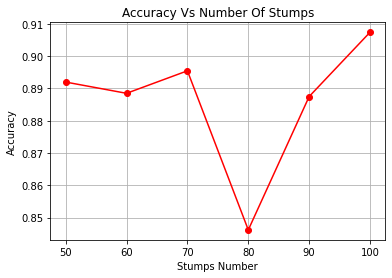

In [22]:
best_k = class_model.validate_adaboost(param_grid_ada, X_cls_validate)

In [23]:
best_k

100

### Predict And Evaluate Adaboost

In [24]:
stumps_amounts_ofSay = class_model.train_adaboost(X_cls_train, best_k)

In [25]:
# check the bias of the model
class_model.test_adaboost(stumps_amounts_ofSay, X_cls_train)

tp: 6634
fn: 222
fp: 585
tn: 599
Sensitivity: 0.9676196032672112
Specificity: 0.5059121621621622
Accuracy: 0.8996268656716417


0.8996268656716417

In [26]:
# check the actual accuracy of the model using new test data
adaboost_acc = class_model.test_adaboost(stumps_amounts_ofSay, X_cls_test)

tp: 2060
fn: 101
fp: 172
tn: 178
Sensitivity: 0.9532623785284591
Specificity: 0.5085714285714286
Accuracy: 0.8912783751493429


### Section D Answer: The Same as Decision Tree...

In [27]:
adaboost_acc

0.8912783751493429

### Conclusion: Observing the results we can see that our Decision Tree and Adaboost models have low bias and low variance which means they neither overfit or underfit the data

# Regression Tree <a class="anchor" id="section1"></a>

### SSR Function

In [18]:
def calc_SSR(left_node, right_node, target_feat):
    left_df = left_node.df
    right_df = right_node.df
    
    left_avg = left_df[target_feat].mean()
    right_avg = right_df[target_feat].mean()
    
    left_col_target = left_df[target_feat]
    right_col_target = right_df[target_feat]
    
    ssr = 0
    
    for cellVal in left_col_target.values:
        ssr = ssr + pow((cellVal - left_avg), 2)
        
    for cellVal in right_col_target.values:
        ssr = ssr + pow((cellVal - right_avg), 2)

    return ssr
    

### Leaf Node Average

In [19]:
def calc_leafNode_avg(node, target_feat):
    node_df = node.df
    node_avg = node_df[target_feat].mean()

    return node_avg

### Regression Tree Model

In [21]:
class regression_Tree(object):  
    def __init__(self, max_depth = None, min_samples_split = 2, target_feature = None, features = None):
        self.max_depth = 6 if max_depth is None else max_depth
        self.min_samples_split = 2 if min_samples_split is None else min_samples_split
        self.target_feature = None if target_feature is None else target_feature
        self.features = features
 
    # get best split base on lowest SSR value
    def best_split(self, df):  
        main_tree = BinaryTree(None, None, None, None, None, None, None)

        ssr_list = {}
        
        target_feat_vals = data[self.target_feature].unique()
        target_feat_vals.sort()
        
        # iterate over the features to get their lowest SSR value
        for feature in list(self.features.keys()):
            tree = BinaryTree(None,None, None, None, None, None, feature)
            mini_df = df.loc[:, [self.target_feature, feature]]
            if self.features[feature]:
                
                feat_vals = df[feature].unique()
                feat_vals.sort()
                
                if len(feat_vals) < 2:
                    continue

                if (mini_df[(mini_df[feature] == feat_vals[0])]).empty or (mini_df[(mini_df[feature] == feat_vals[1])]).empty:
                    continue
                
                df_filtered_classA = mini_df[(mini_df[feature] == feat_vals[0])]
                df_filtered_classB = mini_df[(mini_df[feature] == feat_vals[1])] 
                
                count_row_A = df_filtered_classA.shape[0]
                count_row_B = df_filtered_classB.shape[0]
                
                tree.root.left = Node(count_row_A, None, None, None, None, df_filtered_classA, feature)
                tree.root.right = Node(count_row_B, None, None, None, None, df_filtered_classB, feature)
            
                if feature not in ssr_list:
                    ssr_list[feature] = list()
                    ssr_list[feature].extend([calc_SSR(tree.root.left, tree.root.right, self.target_feature)])

            else:
                selected_col = df.loc[:, feature]
                unique_vals = selected_col.unique()
                sorted_vals = np.sort(unique_vals)
                avg_list = consecutive_avgs(sorted_vals)
                continuous_ssr_list = {}
                 
                if len(avg_list) > 0:     
                    for i in avg_list:   
                        if (mini_df[(mini_df[feature] < i)]).empty or (mini_df[(mini_df[feature] > i)]).empty:
                            continue
                
                        df_filtered_classA = mini_df[(mini_df[feature] < i)]
                        df_filtered_classB = mini_df[(mini_df[feature] > i)]
                        
                        count_row_A = df_filtered_classA.shape[0]
                        count_row_B = df_filtered_classB.shape[0]
            
                        tree.root.left = Node(count_row_A, None, None, None, None, df_filtered_classA, feature)
                        tree.root.right = Node(count_row_B, None, None, None, None, df_filtered_classB, feature)
   
                        continuous_ssr_list[i] = calc_SSR(tree.root.left, tree.root.right, self.target_feature)
        
                    min_ssr_index = min(continuous_ssr_list, key=continuous_ssr_list.get)

                    if feature not in ssr_list:
                        ssr_list[feature] = list()
                        ssr_list[feature].extend([min_ssr_index, continuous_ssr_list[min_ssr_index]])

        min_ssr = None
        min_ssr_feature = None
        
        # get the lowest SSR value with its feature
        for k, v in ssr_list.items():
            if not self.features[k]:
                if min_ssr != None:
                    if v[1] < min_ssr:
                        min_ssr = v[1]
                        min_ssr_feature = k
                else:
                    min_ssr = v[1]
                    min_ssr_feature = k
            else:
                if min_ssr != None:
                    if v[0] < min_ssr:
                        min_ssr = v[0]
                        min_ssr_feature = k
                else:
                    min_ssr = v[0]
                    min_ssr_feature = k
        

        if (min_ssr is None) or (min_ssr_feature is None):
            return None
                
        # build the root with its left and right nodes base on the best feature we found earlier
        if self.features[min_ssr_feature]:
            count_row = df.shape[0]
            feat_vals = df[min_ssr_feature].unique()
            feat_vals.sort()
            
            if (feat_vals[0] is None) or (feat_vals[1] is None):
                return None
            
            main_tree.root = Node(count_row, None, feat_vals[0], feat_vals[1], ssr_list[min_ssr_feature][0], df, min_ssr_feature)
           
            father_df = main_tree.root.df
            if (father_df[father_df[main_tree.root.feature] == main_tree.root.pathValue1]).empty or (father_df[father_df[main_tree.root.feature] == main_tree.root.pathValue2]).empty:
                return None
            
            leftNode_df = father_df[father_df[main_tree.root.feature] == main_tree.root.pathValue1]
            rightNode_df = father_df[father_df[main_tree.root.feature] == main_tree.root.pathValue2]

            count_row_A = leftNode_df.shape[0]
            count_row_B = rightNode_df.shape[0]
            
            main_tree.root.left = Node(count_row_A, None, None, None, None, leftNode_df, None)
            main_tree.root.right = Node(count_row_B, None, None, None, None, rightNode_df, None)
        else:  
            count_row = df.shape[0]
                        
            main_tree.root = Node(count_row, None, (-1 * ssr_list[min_ssr_feature][0]), ssr_list[min_ssr_feature][0], ssr_list[min_ssr_feature][1], df, min_ssr_feature)
           
            father_df = main_tree.root.df
            if (father_df[father_df[main_tree.root.feature] < abs(main_tree.root.pathValue1)]).empty or (father_df[father_df[main_tree.root.feature] > main_tree.root.pathValue2]).empty:
                return None
            
            leftNode_df = father_df[father_df[main_tree.root.feature] < abs(main_tree.root.pathValue1)]
            rightNode_df = father_df[father_df[main_tree.root.feature] > main_tree.root.pathValue2]
            
            count_row_A = leftNode_df.shape[0]
            count_row_B = rightNode_df.shape[0]

            main_tree.root.left = Node(count_row_A, None, None, None, None, leftNode_df, None)
            main_tree.root.right = Node(count_row_B, None, None, None, None, rightNode_df, None)
   
        return main_tree.root
            
    # recursively build the tree
    def add_node(self, root, depth):
        if (root is None) or (root.left is None) or (root.right is None):
            return

        if root.classASize < self.min_samples_split:
            return
        
        if depth > self.max_depth:
            return;
        
        root.left = self.add_node(self.best_split(root.left.df), depth + 1)
        root.right = self.add_node(self.best_split(root.right.df), depth + 1)
        return root;

    #train and test the final model
    def train_test_model(self, df, train_data, test_data):                
        count_row = train_data.shape[0]

        tree = BinaryTree(count_row,None, None, None, None, train_data, None)
        
        tree.root = self.best_split(tree.root.df)
        
        test = self.add_node(tree.root, 0)
        
        true_list = []
        predicted_list = []
        
        # testing phase
        for i in range(test_data.index[0], test_data.index[-1]):
            dff = test_data.loc[i:i, :]
            tmp = dff[self.target_feature].tolist()
            true_list.append(tmp[0])
            predicted_val = self.test_tree(test, dff)
            predicted_list.append(predicted_val)

        # Mean Squared Error
        MSE = round(mean_squared_error(true_list, predicted_list), 6)

        print("MSE: " + str(MSE))
        
        return MSE
        
    
    # this function validates the model with given hyper-parameters
    def validate_model(self, df, parms_list, validation_data):        
        #validation_data = df.loc[8041:10050, :]
        max_depth = 0
        best_mse = -1
        depths = []
        depth_mse = []
        
        for i in range(parms_list["max_depth"][0], parms_list["max_depth"][1] + 1):
            depths.append(i)
            self.max_depth = i
                        
            count_row = validation_data.shape[0]

            tree = BinaryTree(count_row,None, None, None, None, df, None)
        
            tree.root = self.best_split(tree.root.df)
        
            reg_tree = self.add_node(tree.root, 0)
        
            true_list = []
            predicted_list = []
        
            # validation phase
            for j in range(validation_data.index[0], validation_data.index[-1]):
                dff = validation_data.loc[j:j, :]
                tmp = dff[self.target_feature].tolist()
                true_list.append(tmp[0])
                predicted_val = self.test_tree(reg_tree, dff)
                predicted_list.append(predicted_val)
        
            MSE = round(mean_squared_error(true_list, predicted_list), 6)

            depth_mse.append(MSE)
            
            if best_mse < 0:
                best_mse = MSE
                max_depth = i
            if best_mse > MSE:
                best_mse = MSE
                max_depth = i
            
            
        plt.plot(depths, depth_mse, color='red', marker='o')
        plt.title('MSE Vs Tree Depth')
        plt.xlabel('Depth')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()
        
        return max_depth
    
    # test each row and return its selected output class
    def test_tree(self, root, row):
        while(root.left is not None and root.right is not None):
            tmp = row[root.feature].tolist()
            if self.features[root.feature]:
                if tmp[0] == root.pathValue1:
                    root = root.left
                else:
                    root = root.right
            else:   
                if tmp[0] < root.pathValue2:
                    root = root.left
                else:
                    root = root.right

        return calc_leafNode_avg(root, self.target_feature)


### Regression Data

In [22]:
reg_target_feat = "price in rupees"
# True = Categorical, False = Continuous
reg_features_list = {"bedrooms":False, "area_type":True, "ranked":False, "total_sqft":False, "balcony":False, "bath":False, "availability":True}

In [23]:
X_cls_train = data.loc[:8040, :]
X_cls_validate = data.loc[8041:10050, :]
X_cls_test = data.loc[10051:12563, :]

### Define The Regression Tree Model

In [24]:
reg_model = regression_Tree(6, 2, reg_target_feat, reg_features_list)

### Fit The Regression Tree Model

### Note: Only Max Depth Can Be Tuned

In [25]:
# define parameter grid
parameters_grid = {
    'max_depth': [2, 10],
}

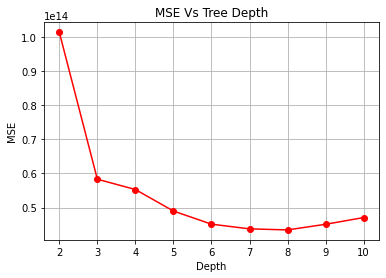

In [26]:
reg_best_depth = reg_model.validate_model(X_cls_train, parameters_grid, X_cls_validate)

In [27]:
reg_best_depth

8

In [28]:
reg_model.max_depth = reg_best_depth

### Predict And Evaluate The Decision Tree Model

In [29]:
# check the bias of the model
reg_model.train_test_model(data, X_cls_train, X_cls_train)

MSE: 37828702717182.11


37828702717182.11

In [30]:
# check the actual MSE of the model using new test data
model_mse = reg_model.train_test_model(data, X_cls_train, X_cls_test)

MSE: 74405722751254.38


In [31]:
model_mse

74405722751254.38

### Conclusion: Observing the results we can see that our Regression Tree model has a high variance and low bias which means it overfits the training data

# Comparison With Sklearn Built-In Models <a class="anchor" id="section1"></a>

### Libraries 

In [32]:
# decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# random forest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# model building
from sklearn.model_selection import train_test_split, GridSearchCV

# model evaluation
from sklearn.metrics import accuracy_score, mean_squared_error

# set seed for reproducible results
RSEED = 10

from sklearn import preprocessing # normalizing for regression tree

### Classification Data

In [42]:
X_cls = data[['availability', 'bedrooms', 'total_sqft', 'bath', 'balcony', 'ranked', 'price in rupees']]
y_cls = data['area_type']

In [43]:
X_cls_train = X_cls.loc[:8040, :]
X_cls_test = X_cls.loc[10051:12563, :]
y_cls_train = y_cls.loc[:8040]
y_cls_test = y_cls.loc[10051:12563]

### Define the Model

In [44]:
# define model
dt = DecisionTreeClassifier(random_state=RSEED, max_depth = class_best_depth, min_samples_split = 2)

### Fit the Model

In [73]:
# fit estimator
dt = dt.fit(X_cls_train,y_cls_train)

### Predict 

In [74]:
# predict
y_cls_pred = dt.predict(X_cls_test)

### Evaluate the Model

In [76]:
# calculate accuracy
acc = round(accuracy_score(y_cls_test, y_cls_pred), 6)

df = pd.DataFrame([acc]).T
df = df.rename(index={0: 'Decision Tree Classifier'}, columns={0: 'SkLearn Accuracy'})
df["Our Accuracy"] = dt_accuracy
df

,SkLearn Accuracy,Our Accuracy
Decision Tree Classifier,0.909236,0.905217


### Conclusion: We got a pretty close accuracy to sklearn model with a difference of only 0.004019, a possible explanation for this difference could be the way in which sklearn implements its classifier and the number of hyper-parameters it uses, even though we gave sklearn model only the max_depth and min_samples_split hyper-parameters doesn't mean that its going to build the model based on these parameters alone instead it sets the other hyper-parameters to their default state and uses them nonetheless, so in conclusion the main reason for this difference in accuracies could be based off of the number of hyper-parameters used to build each model

### Regression Data

In [33]:
X_reg = data[['availability', 'bedrooms', 'total_sqft', 'bath', 'balcony', 'ranked']]
y_reg = data['price in rupees']

In [34]:
X_reg_train = X_reg.loc[:8040, :]
X_reg_test = X_reg.loc[10051:12563, :]
y_reg_train = y_reg.loc[:8040]
y_reg_test = y_reg.loc[10051:12563]

### Define the Model

In [35]:
# define model
rt = DecisionTreeRegressor(max_depth = reg_best_depth, min_samples_split = 2)

### Fit the Model

In [69]:
# fit estimator
rt = rt.fit(X_reg_train,y_reg_train)

### Predict

In [70]:
# predict
y_pred = rt.predict(X_reg_test)

### Evaluate the Model


In [71]:
#min_max_scaler = preprocessing.MinMaxScaler()
#y_reg_test_norm = min_max_scaler.fit_transform(y_reg_test.values.reshape(-1,1))
#y_pred_norm = min_max_scaler.fit_transform(y_pred.reshape(-1,1))
# calculate MSE
MSE = round(mean_squared_error(y_reg_test, y_pred), 6)

df = pd.DataFrame([MSE]).T
df = df.rename(index={0: 'Decision Tree Regressor'}, columns={0: 'MSE'})
df["Our MSE"] = model_mse
df

,MSE,Our MSE
Decision Tree Regressor,7.661343e+13,7.440572e+13


### Conclusion: We got a better MSE than sklearn model , a possible explanation for this difference could be the way in which sklearn implements its regressor and the number of hyper-parameters it uses, even though we gave sklearn model only the max_depth and min_samples_split hyper-parameters doesn't mean that its going to build the model based on these parameters alone instead it sets the other hyper-parameters to their default state and uses them nonetheless, so in conclusion the main reason for this difference in MSE values could be based off of the number of hyper-parameters used to build each model

# AdaBoost <a class="anchor" id="section3"></a>


### Libraries

In [66]:
# adaboost
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
# model building
from sklearn.model_selection import train_test_split, GridSearchCV

# model evaluation
from sklearn.metrics import accuracy_score, mean_squared_error

# set seed for reproducible results
RSEED = 10

### Classification Data

In [67]:
X_cls_adaboost = data[['availability', 'bedrooms', 'total_sqft', 'bath', 'balcony', 'ranked', 'price in rupees']]
y_cls_adaboost = data['area_type']

In [68]:
X_cls_train_ada = X_cls_adaboost.loc[:8040, :]
X_cls_test_ada = X_cls_adaboost.loc[10051:12563, :]
y_cls_train_ada = y_cls_adaboost.loc[:8040]
y_cls_test_ada = y_cls_adaboost.loc[10051:12563]

### Define The Model

In [69]:
# define model
ab = AdaBoostClassifier(n_estimators = best_k)

### Fit The Model

In [70]:
# fit estimator
ab = ab.fit(X_cls_train_ada, y_cls_train_ada)

### Predict

In [77]:
# predict
y_pred_ada = ab.predict(X_cls_test)

### Evaluate The Model

In [78]:
# calculate accuracy
acc = round(accuracy_score(y_cls_test, y_pred_ada), 6)

df = pd.DataFrame([acc]).T
df = df.rename(index={0: 'AdaBoost Classifier'}, columns={0: 'Accuracy'})
df["Our Accuracy"] = adaboost_acc
df

,Accuracy,Our Accuracy
AdaBoost Classifier,0.903662,0.891278


### Conclusion: We got a pretty close accuracy to sklearn model with a difference of only 0.012384, a possible explanation for this difference could be the way in which sklearn implements its classifier and the number of hyper-parameters it uses, even though we gave sklearn model only the n_estimators hyper-parameter doesn't mean that its going to build the model based on this parameter alone instead it sets the other hyper-parameters to their default state and uses them nonetheless, so in conclusion the main reason for this difference in accuracies could be based off of the number of hyper-parameters used to build each model